In [1]:
# Importing Libraries And Modules
import os
import numpy as np
import tensorflow as tf                                                 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

##### Processing The Labels of The Raw IMDB Data

In [2]:
imdb_dir = "/Users/huzaifa/Documents/Datasets/aclImdb"

In [3]:
train_dir = os.path.join(imdb_dir, 'train')

In [4]:
labels = []
texts = []

In [5]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

##### Tokenizing The Text of The Raw IMDB Data

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [7]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [8]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
words_index = tokenizer.word_index
print('Found %s unique tokens.' % len(words_index))

Found 88582 unique tokens.


In [10]:
data = pad_sequences(sequences, maxlen = max_len)

In [11]:
labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [13]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

##### Prepairing The GLoVE Word Embeddings File

In [14]:
glove_dir = '/Users/huzaifa/Documents/Datasets/glove'

In [15]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

In [16]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


##### Prepairing The GLoVE Word Embeddings Matrix

In [17]:
embedding_dim = 100

In [18]:
embedding_matrix = np.zeros((max_words, embedding_dim))

In [19]:
for word, i in words_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

##### Model Definition

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = max_len))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### Loading Pretrained Word Embeddings Into The Embedding Layer

In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

##### Training And Evaluation

In [23]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [24]:
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32,
                    validation_data = (x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 116ms/step - loss: 1.9215 - acc: 0.4850 - val_loss: 0.6924 - val_acc: 0.5114
Epoch 2/10
7/7 [==============================] - 1s 96ms/step - loss: 0.7049 - acc: 0.6450 - val_loss: 0.7040 - val_acc: 0.5184
Epoch 3/10
7/7 [==============================] - 1s 110ms/step - loss: 0.5226 - acc: 0.7000 - val_loss: 0.7799 - val_acc: 0.5153
Epoch 4/10
7/7 [==============================] - 1s 90ms/step - loss: 0.4964 - acc: 0.7300 - val_loss: 0.6923 - val_acc: 0.5610
Epoch 5/10
7/7 [==============================] - 1s 93ms/step - loss: 0.2719 - acc: 0.9100 - val_loss: 0.9545 - val_acc: 0.5185
Epoch 6/10
7/7 [==============================] - 1s 90ms/step - loss: 0.3191 - acc: 0.8350 - val_loss: 0.8038 - val_acc: 0.5209
Epoch 7/10
7/7 [==============================] - 1s 95ms/step - loss: 0.1158 - acc: 0.9950 - val_loss: 1.4001 - val_acc: 0.5074
Epoch 8/10
7/7 [==============================] - 1s 91ms/step - loss: 0.1717 - acc: 0.9350 - v

In [25]:
model.save_weights('pretrained_glove_model.h5')

##### Plotting The Results

In [26]:
import matplotlib.pyplot as plt

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
epochs = range(1, len(acc) + 1)

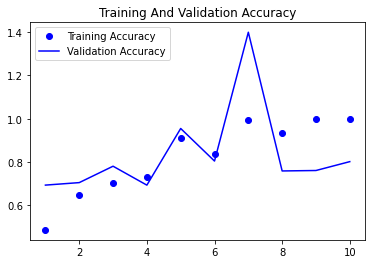

In [29]:
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation Accuracy')
plt.title("Training And Validation Accuracy")
plt.legend()

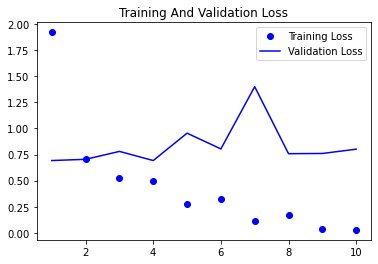

In [30]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()

##### Training The Same Model Without Pretrained Word Embeddings

In [31]:
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length = max_len))
model1.add(Flatten())
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [32]:
model1.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
               metrics = ['acc'])

In [33]:
history1 = model1.fit(x_train, y_train, epochs = 10, batch_size = 32, 
                      validation_data = (x_val, y_val)) 

Epoch 1/10
7/7 [==============================] - 1s 120ms/step - loss: 0.6966 - acc: 0.4600 - val_loss: 0.6920 - val_acc: 0.5162
Epoch 2/10
7/7 [==============================] - 1s 103ms/step - loss: 0.4945 - acc: 0.9900 - val_loss: 0.6912 - val_acc: 0.5223
Epoch 3/10
7/7 [==============================] - 1s 88ms/step - loss: 0.2769 - acc: 1.0000 - val_loss: 0.7049 - val_acc: 0.5163
Epoch 4/10
7/7 [==============================] - 1s 86ms/step - loss: 0.1163 - acc: 1.0000 - val_loss: 0.7007 - val_acc: 0.5225
Epoch 5/10
7/7 [==============================] - 1s 103ms/step - loss: 0.0542 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.5354
Epoch 6/10
7/7 [==============================] - 1s 94ms/step - loss: 0.0271 - acc: 1.0000 - val_loss: 0.7040 - val_acc: 0.5348
Epoch 7/10
7/7 [==============================] - 1s 121ms/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.7099 - val_acc: 0.5340
Epoch 8/10
7/7 [==============================] - 1s 105ms/step - loss: 0.0087 - acc: 1.0000 

##### PLotting The Results

In [34]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [35]:
epochs = range(1, len(acc) + 1)

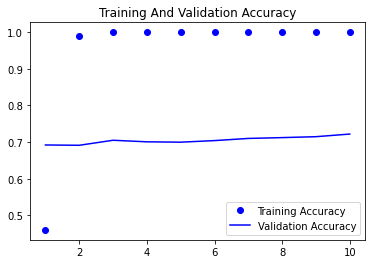

In [36]:
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation Accuracy')
plt.title("Training And Validation Accuracy")
plt.legend()

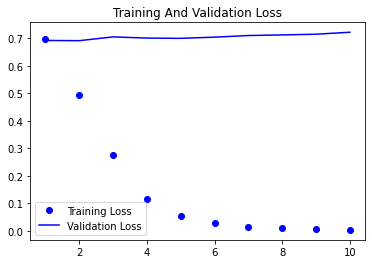

In [37]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
plt.show()

##### Tokenizing The Data of The Test Set

In [38]:
test_dir = os.path.join(imdb_dir, 'test')

In [39]:
labels = []
texts = []

In [40]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
        f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

In [41]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = max_len)
y_test = np.asarray(labels)

##### Evaluating The Model On The Test Data

In [42]:
model.load_weights('pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.8161 - acc: 0.5636


[0.8161294460296631, 0.5636399984359741]